In [ ]:
import torch

print(f"CUDA có sẵn: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Tên thiết bị CUDA: {torch.cuda.get_device_name(0)}")
else:
    print("Không tìm thấy GPU. Huấn luyện sẽ diễn ra trên CPU (rất chậm).")

!pip install timm torchinfo

print("\nCài đặt thư viện hoàn tất.")

CUDA có sẵn: True
Tên thiết bị CUDA: Tesla T4

Cài đặt thư viện hoàn tất.


In [ ]:

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import timm
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

In [ ]:

# Kích thước chuẩn cho ViT là 224x224
IMG_SIZE_VIT = 224
BATCH_SIZE = 128

# Định nghĩa các phép biến đổi dữ liệu cho Vision Transformer (ViT)
train_transform_vit = transforms.Compose([
    transforms.Resize((IMG_SIZE_VIT, IMG_SIZE_VIT)),
    transforms.RandomCrop(IMG_SIZE_VIT, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100 mean and std
])

test_transform_vit = transforms.Compose([
    transforms.Resize((IMG_SIZE_VIT, IMG_SIZE_VIT)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100 mean and std
])

# Ở đây chúng ta giữ 32x32 để so sánh với ViT đã được resize
train_transform_cnn = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

test_transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


# Tải bộ dữ liệu CIFAR-100 với các transform riêng cho ViT và CNN
print("Đang tải và tiền xử lý bộ dữ liệu CIFAR-100...")
train_dataset_vit = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform_vit)
test_dataset_vit = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform_vit)

train_dataset_cnn = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform_cnn)
test_dataset_cnn = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform_cnn)

# Tạo DataLoader
train_loader_vit = DataLoader(train_dataset_vit, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Lấy tên các lớp (classes)
classes = train_dataset_vit.classes
num_classes = len(classes)
print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {classes[:5]}...")
print("Tiền xử lý dữ liệu hoàn tất.")

Đang tải và tiền xử lý bộ dữ liệu CIFAR-100...
Số lượng lớp: 100
Các lớp: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver']...
Tiền xử lý dữ liệu hoàn tất.


In [ ]:

class VisionTransformerCIFAR100(nn.Module):
    def __init__(self, num_classes=100, pretrained=True):
        super(VisionTransformerCIFAR100, self).__init__()

        self.vit = timm.create_model('vit_tiny_patch16_224', pretrained=pretrained)
        num_ftrs = self.vit.head.in_features
        self.vit.head = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.vit(x)

# Khởi tạo mô hình ViT
vit_model = VisionTransformerCIFAR100(num_classes=num_classes, pretrained=True)
print("Mô hình Vision Transformer đã sẵn sàng.")

Mô hình Vision Transformer đã sẵn sàng.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

class ResNet18CIFAR100(nn.Module):
    def __init__(self, num_classes=100, pretrained=True):
        super(ResNet18CIFAR100, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Khởi tạo mô hình CNN
cnn_model = ResNet18CIFAR100(num_classes=num_classes, pretrained=True)
print("Mô hình ResNet18 đã sẵn sàng.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mô hình ResNet18 đã sẵn sàng.


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001, input_img_size=32):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs) # Lịch trình học

    print(f"\n--- Huấn luyện mô hình: {model.__class__.__name__} ---")
    print(summary(model, input_size=(BATCH_SIZE, 3, input_img_size, input_img_size)))

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    best_test_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100. * correct_test / total_test
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), f'best_{model.__class__.__name__.lower()}.pth')

    print(f"Huấn luyện hoàn tất. Best Test Acc: {best_test_acc:.2f}%")
    return history

Đang sử dụng thiết bị: cuda


In [ ]:
NUM_EPOCHS = 10

# Huấn luyện mô hình ViT
print("\nBắt đầu huấn luyện Vision Transformer...")
vit_history = train_model(vit_model, train_loader_vit, test_loader_vit, num_epochs=NUM_EPOCHS, learning_rate=0.0005, input_img_size=IMG_SIZE_VIT)

# Huấn luyện mô hình CNN
print("\nBắt đầu huấn luyện ResNet18 (CNN)...")
cnn_history = train_model(cnn_model, train_loader_cnn, test_loader_cnn, num_epochs=NUM_EPOCHS, learning_rate=0.001, input_img_size=32)


Bắt đầu huấn luyện Vision Transformer...

--- Huấn luyện mô hình: VisionTransformerCIFAR100 ---
Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformerCIFAR100                     [128, 100]                --
├─VisionTransformer: 1-1                      [128, 100]                38,016
│    └─PatchEmbed: 2-1                        [128, 196, 192]           --
│    │    └─Conv2d: 3-1                       [128, 192, 14, 14]        147,648
│    │    └─Identity: 3-2                     [128, 196, 192]           --
│    └─Dropout: 2-2                           [128, 197, 192]           --
│    └─Identity: 2-3                          [128, 197, 192]           --
│    └─Identity: 2-4                          [128, 197, 192]           --
│    └─Sequential: 2-5                        [128, 197, 192]           --
│    │    └─Block: 3-3                        [128, 197, 192]           444,864
│    │    └─Block: 3-4                        [128, 197, 19

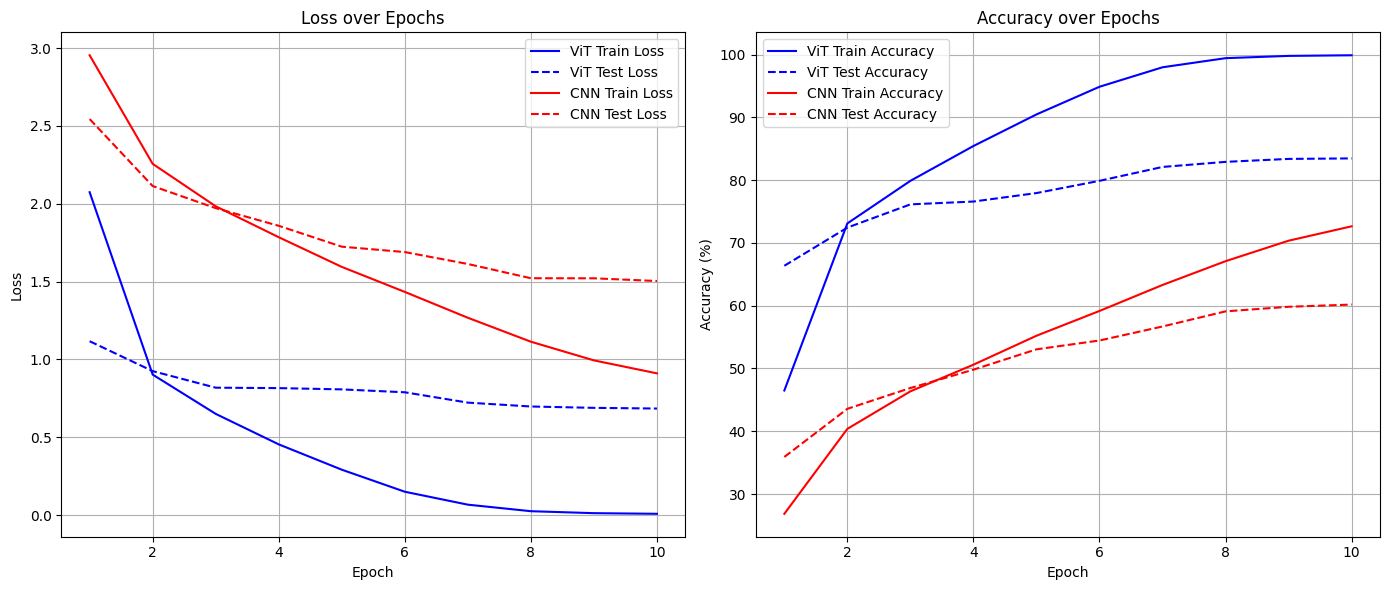


--- So sánh hiệu suất cuối cùng ---
Vision Transformer (ViT) Final Test Accuracy: 83.46%
ResNet18 (CNN) Final Test Accuracy: 60.18%


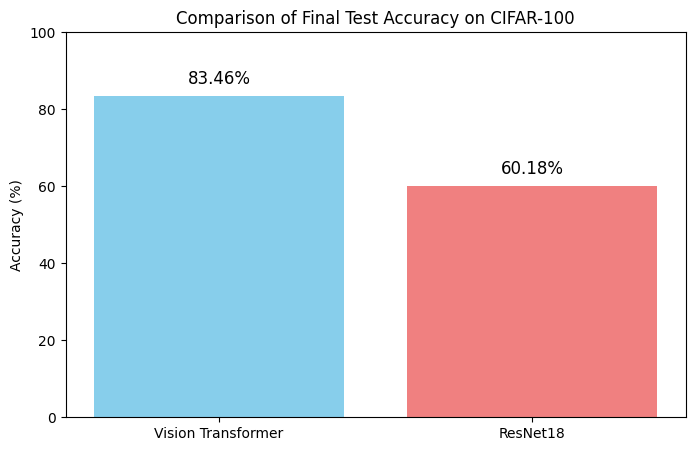

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(vit_history, cnn_history):
    epochs = np.arange(1, len(vit_history['train_loss']) + 1)

    plt.figure(figsize=(14, 6))

    # Biểu đồ Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, vit_history['train_loss'], label='ViT Train Loss', color='blue')
    plt.plot(epochs, vit_history['test_loss'], label='ViT Test Loss', linestyle='--', color='blue')
    plt.plot(epochs, cnn_history['train_loss'], label='CNN Train Loss', color='red')
    plt.plot(epochs, cnn_history['test_loss'], label='CNN Test Loss', linestyle='--', color='red')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, vit_history['train_acc'], label='ViT Train Accuracy', color='blue')
    plt.plot(epochs, vit_history['test_acc'], label='ViT Test Accuracy', linestyle='--', color='blue')
    plt.plot(epochs, cnn_history['train_acc'], label='CNN Train Accuracy', color='red')
    plt.plot(epochs, cnn_history['test_acc'], label='CNN Test Accuracy', linestyle='--', color='red')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(vit_history, cnn_history)

# So sánh accuracy cuối cùng
vit_final_acc = vit_history['test_acc'][-1]
cnn_final_acc = cnn_history['test_acc'][-1]

print(f"\n--- So sánh hiệu suất cuối cùng ---")
print(f"Vision Transformer (ViT) Final Test Accuracy: {vit_final_acc:.2f}%")
print(f"ResNet18 (CNN) Final Test Accuracy: {cnn_final_acc:.2f}%")

# Vẽ biểu đồ cột so sánh accuracy
models = ['Vision Transformer', 'ResNet18']
accuracies = [vit_final_acc, cnn_final_acc]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Final Test Accuracy on CIFAR-100')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 2, f"{v:.2f}%", ha='center', va='bottom', fontsize=12)
plt.show()

--- Dự đoán của Vision Transformer ---
Thực tế (Ground Truth):  mountain forest seal  mushroom


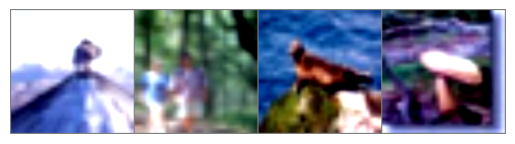

ViT Dự đoán:           road  kangaroo seal  mushroom

--- Dự đoán của ResNet18 (CNN) ---
Thực tế (Ground Truth):  mountain forest seal  mushroom


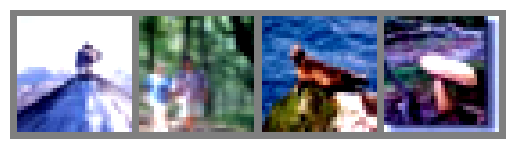

CNN Dự đoán:           train forest otter mushroom


In [ ]:

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Chọn một batch ảnh từ tập kiểm tra ViT (đã được resize 224x224)
dataiter_vit = iter(test_loader_vit)
images_vit, labels_vit = next(dataiter_vit)

print('--- Dự đoán của Vision Transformer ---')
print('Thực tế (Ground Truth): ', ' '.join(f'{classes[labels_vit[j]]:5s}' for j in range(4)))
imshow(torchvision.utils.make_grid(images_vit[:4].cpu())) # Chuyển về CPU để hiển thị

# Dự đoán bằng ViT
vit_model.eval()
outputs_vit = vit_model(images_vit.to(device))
_, predicted_vit = torch.max(outputs_vit, 1)
print('ViT Dự đoán:          ', ' '.join(f'{classes[predicted_vit[j]]:5s}' for j in range(4)))



dataiter_cnn = iter(test_loader_cnn)
images_cnn, labels_cnn = next(dataiter_cnn)


print('\n--- Dự đoán của ResNet18 (CNN) ---')
print('Thực tế (Ground Truth): ', ' '.join(f'{classes[labels_cnn[j]]:5s}' for j in range(4)))
imshow(torchvision.utils.make_grid(images_cnn[:4].cpu())) # Chuyển về CPU để hiển thị

cnn_model.eval()
outputs_cnn = cnn_model(images_cnn.to(device))
_, predicted_cnn = torch.max(outputs_cnn, 1)
print('CNN Dự đoán:          ', ' '.join(f'{classes[predicted_cnn[j]]:5s}' for j in range(4)))